# ELE435/535 - LAB 9

## Main Parts of the LAB:
## 1) Kernel-PCA on synthetic data
## 2) Kernel-SVM and Kernel-RR on MNIST
## 3) Kernel-Nearest Neighbor on Liver Disorders Dataset
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************


## 1) Kernel-PCA

In this assignment, we will study the effectiveness of kernel PCA.

1-1) Import the given data "LAB9_data_PCA.npy" into numpy. It contains 1000 points, the first 500 of which belongs to class #1 and the rest belongs to class #2. Each row corresponds to one data point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from time import time
import datetime
%matplotlib inline

In [2]:
data = np.load('LAB9_data_PCA.npy')
print(data.shape)
print(data[0,:])

(1000, 3)
[-89.30063353 -45.25614115   4.74182288]


1-2) Visualize the data in 3D. Use different colors for objects from distinct classes.

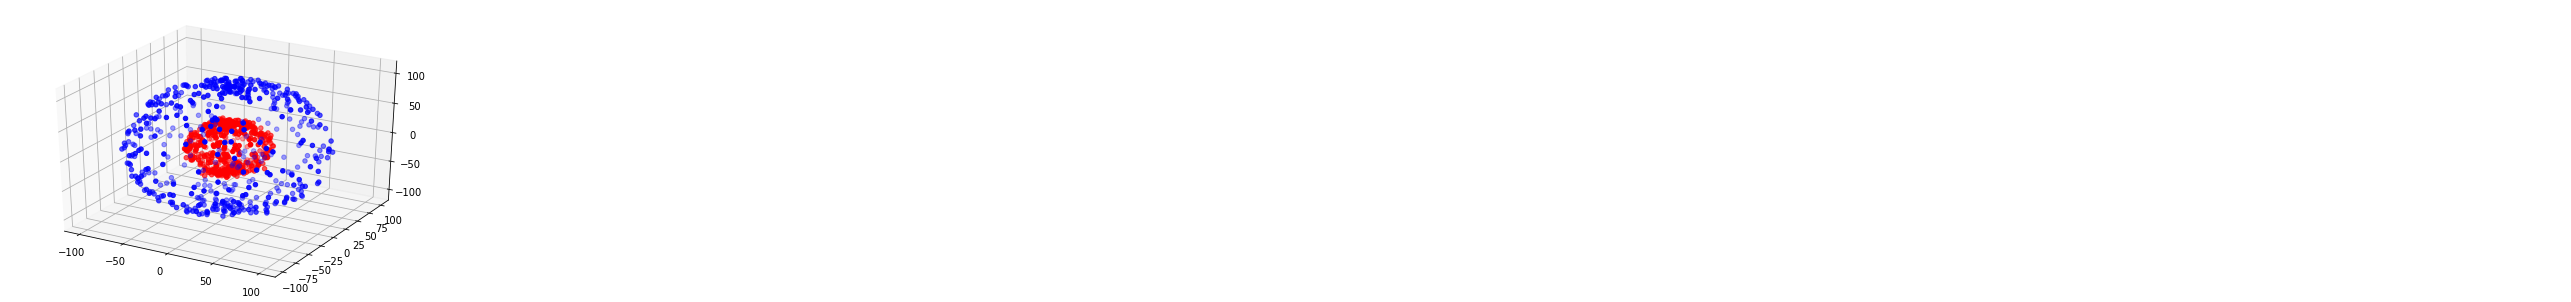

In [3]:
ax = Axes3D(plt.gcf())
ax.scatter(xs=data[0:500,0], ys=data[0:500,1], zs=data[0:500,2], c='blue')
ax.scatter(xs=data[500:1000,0], ys=data[500:1000,1], zs=data[500:1000,2], c='red')

1-3) Now perform a normal PCA (i.e. linear PCA) over the data (you may use sklearn's built-in commands for this part). Then project the data onto the span of the first two principal components. Visualize the projected data in 2D. 

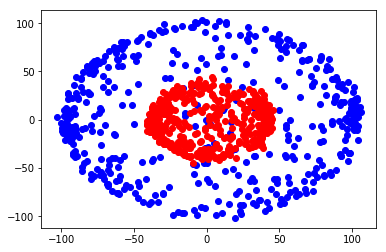

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_X = pca.fit_transform(data)

plt.figure()
plt.scatter(pca_X[0:500, 0], pca_X[0:500,1], c='blue')
plt.scatter(pca_X[500:1000, 0], pca_X[500:1000,1], c='red')

1-4) Now, perform kernel PCA with a 4-th order inhomogeneous polynomial kernel. Then, project the data onto the span of first two principal components and visualize the projected data in 2D **(do not use sklearn's built-in commands for this part; follow the steps mentioned in the notes, e.g. find the Gram matrix of the centered data, then use SVD, etc.)**

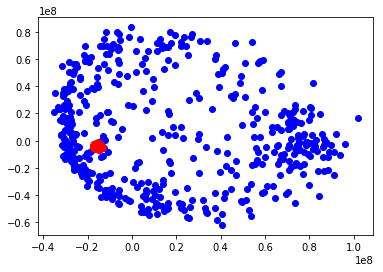

In [5]:
m = data.shape[0]
kernel_pca_x = np.zeros((1000,1000))

for i in range(m):
    for j in range(m):
        kernel_pca_x[i,j] = (1 + data[i,:].T @ data[j, :])**4
        
ones = np.ones((1000,1))
kernel_pca_x = kernel_pca_x - 1/m * ones @ ones.T @ kernel_pca_x - 1/m * kernel_pca_x @ ones @ ones.T + 1/m**2 * (ones.T @ kernel_pca_x @ ones) * ones @ ones.T
u, s, vh = np.linalg.svd(kernel_pca_x)

v_1 = np.sqrt(s[0])*u[:,0]
v_2 = np.sqrt(s[1])*u[:,1]

plt.figure()
plt.scatter(v_1[0:500], v_2[0:500], c='blue')
plt.scatter(v_1[500:1000], v_2[500:1000], c='red')

1-5) Implement kernel PCA with the RBF kernel **(do not use sklearn's built-in commands; follow the steps in the notes--similar to what you did in the previous part) **
$(k(x,z) = e^{-\gamma \lVert {x-z} \lVert_2^2}, \gamma = 1/2\sigma^2)$.
Choose sigma to be 10, 30, and 100. Also, visualize the projected data onto the span of the first two principal components for each value of sigma.

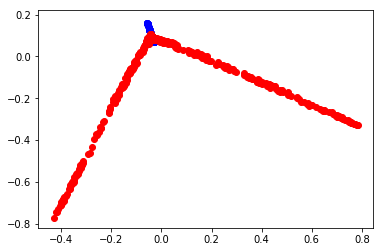

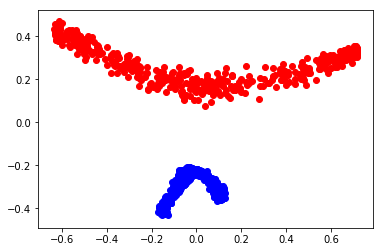

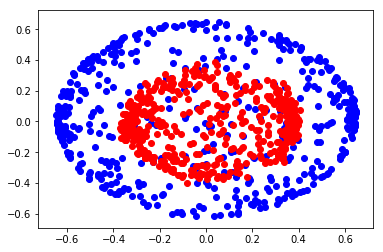

In [6]:
m = data.shape[0]
kernel_pca_x = np.zeros((1000,1000))
gammas = [1/200, 1/1800, 1/20000]

for gamma in gammas:
    for i in range(m):
        for j in range(m):
            kernel_pca_x[i,j] = np.exp(-gamma*np.linalg.norm(data[i,:] - data[j,:])**2)

    ones = np.ones((1000,1))
    kernel_pca_x = kernel_pca_x - 1/m * ones @ ones.T @ kernel_pca_x - 1/m * kernel_pca_x @ ones @ ones.T + 1/m**2 * (ones.T @ kernel_pca_x @ ones) * ones @ ones.T
    u, s, vh = np.linalg.svd(kernel_pca_x)

    v_1 = np.sqrt(s[0])*u[:,0]
    v_2 = np.sqrt(s[1])*u[:,1]

    plt.figure()
    plt.scatter(v_1[0:500], v_2[0:500], c='blue')
    plt.scatter(v_1[500:1000], v_2[500:1000], c='red')

1-6) How can you estimate a suitable value of sigma given a dataset? i.e., give a metric to estimate an appropriate value of sigma given some data points.  

The goal of using kernels is to transform the data to a more appropriate form for your application. Thus, after performing the transformations using an RBF with parameter $\sigma$ then you should complete your ML task with the transformed data set and use whatever metric is appropriate for your problem (accuracy for classification, L2 error for regression, etc.) Alternatively, another goal of kernels is to make the data separable, thus running SVM on the transformed data and using the objective of the primal SVM problem would be a good metric. That is, if the data becomes separable, the objective will become 0 (like $\sigma = 30$ in the previous part).

## 2) Kernel-SVM and Kernel-RR on MNIST

In this part, we will use kernel-SVM and kernel-RR to classify MNIST digits. 


2-1) First, import the subset of MNIST dataset that we were working on in the previous labs. 

In [7]:
train_data = np.load('./MNISTcwtrain1000.npy')
train_data = train_data.astype(dtype='float64')
test_data = np.load('./MNISTcwtest100.npy')
test_data = test_data.astype(dtype='float64')

train_data = train_data/255.0
test_data = test_data/255.0

2-2) Report the classification accuracy on the testing data using kernel-SVM with a 'linear' kernel. (You may use sklearn's built-in commands for this part. If you use LinearSVC, make sure to change the loss argument to 'hinge', as unlike SVC, LinearSVC uses the squared hinge loss by default.)

In [8]:
from sklearn.svm import SVC

true_label = np.zeros((10000,))

for i in range(0,10):
    true_label[i*1000:(i+1)*1000] = i

clf = SVC(kernel='linear')
clf.fit(train_data.T, true_label)

predicted_label = clf.predict(test_data.T)
true_label = np.zeros((1000,))

for i in range(0,10):
    true_label[i*100:(i+1)*100] = i

test_err = np.count_nonzero(predicted_label - true_label)
test_acc = 1-(test_err/1000.0)

print("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.911


2-3) Now, use SVM with 'rbf' kernel. Select three different values of 'gamma' and report how the test accuracy changes. (you may use sklearn's built-in commands for this part) Hint: In order to get a feeling for selecting an appropriate value for gamma, take a look at http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html.

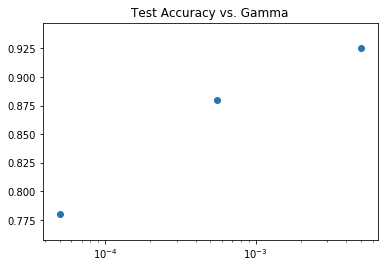

In [9]:
gammas = [1/200, 1/1800, 1/20000]
accuracies_arr = []

for gamma in gammas:
    true_label = np.zeros((10000,))

    for i in range(0,10):
        true_label[i*1000:(i+1)*1000] = i

    clf = SVC(kernel='rbf', gamma=gamma)
    clf.fit(train_data.T, true_label)

    predicted_label = clf.predict(test_data.T)
    true_label = np.zeros((1000,))

    for i in range(0,10):
        true_label[i*100:(i+1)*100] = i

    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/1000.0)
    accuracies_arr.append(test_acc)
    
plt.figure()
plt.xscale('log')
plt.scatter(gammas, accuracies_arr)
plt.title('Test Accuracy vs. Gamma')
plt.show()

2-4) Repeat 2-3 with the Kernel Ridge Classifier. You may use sklearn's KernelRidge, which is normally used for regression. To adopt it for classification, you can perform a binary encoding of the labels using LabeLBinarizer. Check https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html.

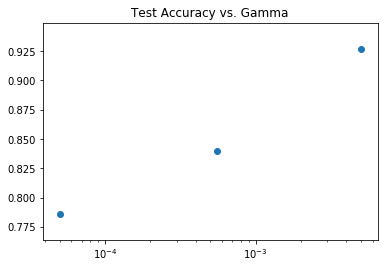

In [10]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelBinarizer

gammas = [1/200, 1/1800, 1/20000]
accuracies_arr = []

for gamma in gammas:
    true_label = np.zeros((10000,))

    for i in range(0,10):
        true_label[i*1000:(i+1)*1000] = i
        
    lb = LabelBinarizer()
    lb = lb.fit(true_label)
        
    clf = KernelRidge(kernel='rbf', gamma=gamma)
    clf.fit(train_data.T, lb.transform(true_label))

    predicted_label = np.argmax(clf.predict(test_data.T), axis=1)
    true_label = np.zeros((1000,))

    for i in range(0,10):
        true_label[i*100:(i+1)*100] = i

    test_err = np.count_nonzero(predicted_label - true_label)
    test_acc = 1-(test_err/1000.0)
    accuracies_arr.append(test_acc)
    
plt.figure()
plt.xscale('log')
plt.scatter(gammas, accuracies_arr)
plt.title('Test Accuracy vs. Gamma')
plt.show()

# 3) Kernel Nearest Neighbor Classifier on Liver Disorders Data Set

In this part, we will be working with BUPA Liver Disorder database from BUPA Medical Research Ltd. (http://archive.ics.uci.edu/ml/datasets/Liver+Disorders). It contains data from 345 male individuals. We have selected the first 245 samples to form the training data and the rest as testing data. 

The first 5 features are results from blood tests. They are sensitive to liver disorders that may arise from excessive alcohol consumption. The sixth feature is the number of drinks per day. The last column specifies whether someone has the disorder or not.

In [11]:
X = np.loadtxt('Liver_Dataset.txt')

X_train = X[0:245,0:6]
X_test = X[245:,0:6]
y_train = X[0:245,6]
y_test = X[245:,6]

3-1) Implement 1-nearest neighbor classifier and report the testing accuracy. You may use sklearn's built-in commands for this part.

In [12]:
from sklearn.neighbors import NearestNeighbors

clf = NearestNeighbors(n_neighbors=1)
clf.fit(X_train, y_train)
nn = clf.kneighbors(X_test)

predicted_label = np.zeros((100,))

for i in range(100):
    predicted_label[i] = y_train[nn[1][i]]

test_err = np.count_nonzero(predicted_label - y_test)
test_acc = 1-(test_err/100.0)

print("Test Accuacy :::::: " + str(test_acc))

Test Accuacy :::::: 0.61


3-2) Implement kernel-nearest neighbor classifier using 3-th order inhomogeneous polynomial kernel. Report the testing accuracy. **Do not use sklearn for this part. Follow the steps mentioned in the notes (i.e. through forming the Gram matrix).** How much test accuracy improvement do we achieve using the polynomial kernel?

In [13]:
size = 245
kernel = np.zeros((size,size))

for i in range(size):
    for j in range(size):
        kernel[i,j] = (1 + X_train[i,:].T @ X_train[j,:])**3

n_samples = 100
predicted_label = np.zeros((n_samples,))

for i in range(n_samples):
    test = X_test[i,:]
    max_obj = 2*(1 + test.T @ X_train[0,:])**3 - kernel[0,0]
    max_idx = 0
    
    for j in range(1, size):
        tmp = 2*(1 + test.T @ X_train[j,:])**3 - kernel[j,j]
        
        if tmp > max_obj:
            max_obj = tmp
            max_idx = j
            
    predicted_label[i] = y_train[max_idx]
    
test_err = np.count_nonzero(predicted_label - y_test)
test_acc = 1-(test_err/n_samples)

print("Test Accuacy :::::: " + str(test_acc))
print('The improvement to accuracy is modest being only 0.02.')

Test Accuacy :::::: 0.63
The improvement to accuracy is modest being only 0.02.
